# 2D landscape evolution model (bedrock channel SPL + hillslope diffusion)

The code below runs a simple landscape evolution model using `fastscape`. It starts from extracted elevation data (SRTM) using the [bmi-topography](https://github.com/csdms/bmi-topography) package.

## Goal

- Leverage different Python tools (connecting the dots) to create an interactive, nice-looking dashboard.
- We'll use `ipywidgets`, `ipyleaflet` and `ipygany`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xsimlab as xs

from bmi_topography import Topography
from fastscape.models import basic_model
from fastscape.processes import SurfaceTopography

In [2]:
def extract_dem(north=40.25, south=39.75, west=-105.25, east=-104.75):
    """Extract elevation data using a region of interest."""
    
    params = {
        'dem_type': 'SRTMGL3',
         'south': south,
         'north': north,
         'west': west,
         'east': east,
         'output_format': 'GTiff',
         'cache_dir': '~/.bmi_topography'
    }
    
    topo = Topography(**params)

    print("Fetch topographic data...")
    topo.fetch()

    print("Load dataset...")
    return topo.load()

In [3]:
@xs.process
class InitDEM:
    dem = xs.variable(dims=('y', 'x'))
    elevation = xs.foreign(SurfaceTopography, 'elevation', intent='out')
    
    def initialize(self):
        self.elevation = self.dem
        

model = basic_model.update_processes({'init_topography': InitDEM})


def run_model(dem, U=1e-5, K=2e-6, m=0.6, n=1.5, D=1e-2):
    
    resolution = 90
    grid_shape = [dem.sizes['y'], dem.sizes['x']]
    grid_length = list(np.array(grid_shape) * resolution)
    print(grid_length)

    in_ds = xs.create_setup(
        model=model,
        clocks={
            'time': np.arange(0, 1e6 + 1e4, 2e4),
            'out': np.arange(0, 1e6 + 1e4, 2e4),
        },
        master_clock='time',
        input_vars={
            'grid__shape': grid_shape,
            'grid__length': grid_length,
            'boundary__status': 'fixed_value',
            'init_topography__dem': dem.squeeze().astype('d'),
            'uplift__rate': U,
            'spl': {
                'k_coef': K,
                'area_exp': m,
                'slope_exp': n
            },
            'diffusion__diffusivity': D
        },
        output_vars={
            'topography__elevation': 'out',
        }
    )
    
    print("Starting landscape evolution model run...")
    
    with xs.monitoring.ProgressBar():
        out_ds = in_ds.xsimlab.run(model=model)
    
    return out_ds

In [4]:
dem = extract_dem()
out_ds = run_model(dem)
            

Fetch topographic data...
Load dataset...
[54000, 54000]
Starting landscape evolution model run...


             0% | initialize 

In [5]:
out_ds

<xarray.Dataset>
Dimensions:                 (border: 4, out: 51, shape_yx: 2, time: 51, x: 600, y: 600)
Coordinates:
  * border                  (border) object 'left' 'right' 'top' 'bottom'
  * out                     (out) float64 0.0 2e+04 4e+04 ... 9.8e+05 1e+06
  * time                    (time) float64 0.0 2e+04 4e+04 ... 9.8e+05 1e+06
  * x                       (x) float64 0.0 90.15 180.3 ... 5.391e+04 5.4e+04
  * y                       (y) float64 0.0 90.15 180.3 ... 5.391e+04 5.4e+04
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status        <U11 'fixed_value'
    diffusion__diffusivity  float64 0.01
    grid__length            (shape_yx) int64 54000 54000
    grid__shape             (shape_yx) int64 600 600
    init_topography__dem    (y, x) float64 1.827e+03 1.849e+03 ... 1.688e+03
    spl__area_exp           float64 0.6
    spl__k_coef             float64 2e-06
    spl__slope_exp          float64 1.5
    topography__elevation   (out, y, x) float64 1.827e+03 ... 1.688e+03
    uplift__rate            float64 1e-05

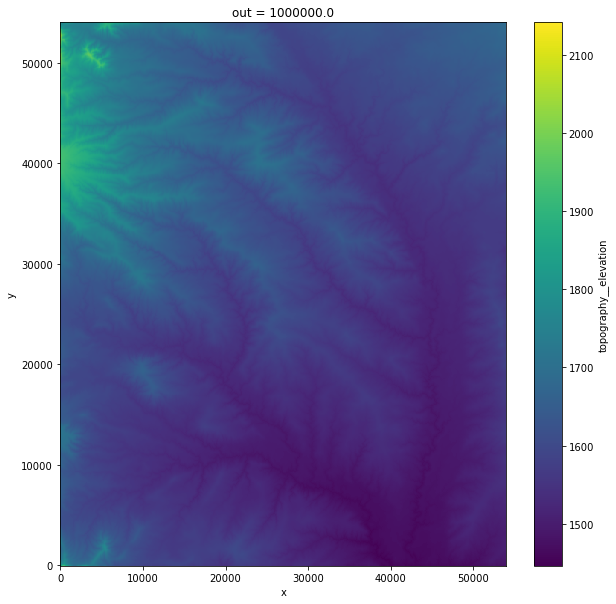

In [6]:
out_ds.topography__elevation.isel(out=-1).plot(aspect=1, size=10);

---

## Exercise 1

Create a map widget that we can use to select a region of interest that is then used to extract DEM data and run a simulation.

Hints:

- use `ipywidgets.DrawControl` to draw a ROI (rectangle) and get the its coordinates
- create a `Button` widget with a callback function that will get the ROI coordinates, download/load DEM data and run the simulation
- create an `Output` widget to log the simulation progress and show the resulting Xarray Dataset

In [7]:
from ipyleaflet import Map, basemaps, DrawControl
import ipywidgets as widgets
from IPython.display import display

In [8]:
m = Map(basemap=basemaps.OpenTopoMap, center=[40, -105], zoom=11)
draw_control = DrawControl()
draw_control.polygon = {}
draw_control.polyline = {}
draw_control.circlemarker = {}
draw_control.rectangle = {
    'shapeOptions': {
        'fillOpacity': 0.5
    }
}
m.add_control(draw_control)

but = widgets.Button(description='Run model')
output = widgets.Output()


def extract_dem_and_run(value):
    roi = draw_control.last_draw['geometry']['coordinates'][0]
    lon, lat = list(zip(*roi))
    
    output.clear_output()
    with output:
        dem = extract_dem(north=max(lat), south=min(lat), east=max(lon), west=min(lon))
        out_ds = run_model(dem)
        display(out_ds)

    
but.on_click(extract_dem_and_run)

widgets.VBox([m, but, output])

## Exercise 2

Let's visualize the final elevation (model output).

Hints:

- create a new `Output` widget that will contain an `ipygany.Scene` widget
- create the ipygany scene using `ipygany.Polymesh` and `ipygany.IsoColor`.
    - you can get the final elevation using `ds_out.topography__elevation.isel(out=-1)` from the output xarray Dataset
    - do `from utils import get_mesh_elements` and use this utility function to get the elevation array as an unstructured mesh (needed by `ipygany.Polymesh`)

Bonuses:

- add widgets for setting custom model parameter values
- animate the model outputs in the ipygany scene (there's an example here: https://nbviewer.jupyter.org/github/QuantStack/ipygany/blob/master/examples/ipygany.ipynb) 

In [9]:
from utils import get_mesh_elements
import ipygany


m = Map(basemap=basemaps.OpenTopoMap, center=[40, -105], zoom=11)
draw_control = DrawControl()
draw_control.polygon = {}
draw_control.polyline = {}
draw_control.circlemarker = {}
draw_control.rectangle = {
    'shapeOptions': {
        'fillOpacity': 0.5
    }
}
m.add_control(draw_control)

but = widgets.Button(description='Run model')
output = widgets.Output()
scene_output = widgets.Output()

def extract_dem_and_run(value):
    roi = draw_control.last_draw['geometry']['coordinates'][0]
    lon, lat = list(zip(*roi))
    
    output.clear_output()
    scene_output.clear_output()

    with output:
        dem = extract_dem(north=max(lat), south=min(lat), east=max(lon), west=min(lon))
        out_ds = run_model(dem)
        display(out_ds)
        
    final_elevation = out_ds.topography__elevation.isel(out=-1)
    triangle_indices, vertices = get_mesh_elements(final_elevation)
        
    height_component = ipygany.Component(name='value', array=final_elevation.values)

    mesh = ipygany.PolyMesh(
        vertices=vertices,
        triangle_indices=triangle_indices,
        data={'height': [height_component]}
    )

    isocolor = ipygany.IsoColor(
        mesh, input=('height', 'value'),
        min=np.min(final_elevation), max=np.max(final_elevation),
    )
        
    scene = ipygany.Scene([isocolor])
    with scene_output:
        display(scene)

    
but.on_click(extract_dem_and_run)

widgets.VBox([m, but, output, scene_output])

ModuleNotFoundError: No module named 'utils'